## Shaft model with regularization PDF (656 samples)

The model consists of the sum of a linear function and a non-linear function with PDF shaping and regularization.

This model uses the CFD Shaft data with 650 samples. Error function plot per output.

## Web application 6 inputs and 5 outputs

Run interactively on the web at:

## Inputs

(1, 'i_pul_coal_inj_kg_thm')

(2, 'i_nat_gas_inj_kg_thm')

(3, 'i_nat_gas_t_k')

(4, 'i_o2_vol_perce')

(9, 'i_ore_moisture_weight_perce')

(11, 'i_ore_weight_kg')

## Outputs

(19, 'o_shaft_co_utiliz')

(20, 'o_shaft_h2_utiliz')

(21, 'o_shaft_top_gas_temp_c')

(22, 'o_shaft_press_drop_pa')

(23, 'o_shaft_coke_rate_kg_thm')

In [1]:

################################################
##
## regression with ML for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


In [103]:

#######################################################
## learning_rate_mse        = 0.0005
## probably needs adjustable learning rate scheduler


N_EPOCHS = 4000                            ## 4000
batch_size = 16                             ## 5    ## 32
learning_rate =  0.1   ## 0.1                        ## 0.01   ## 1e-5 


## 0.0001  experimentally seemed okay 
learning_rate_pdfcontrol  =  0.0001      ## 0.0001     ## 0.00001       ## 0.000001


#######################################################
# define mean and standard deviation of target Gaussian distribution (impulse function)

mean_impulse = 0.
std_impulse  = 0.01

#######################################################


## experimentally 0.5 - 0.7 was interesting      ## 0.9
h = 0.9       ## 0.7    ## 0.05     ## 0.03                    ## 0.05 >


## experimentally 20 seemed okay 
N_error_range =  20          ## 20  ## 10   ## error between pred and real range (-20, 20)

switch_threshold = 0.8    ## 0.90

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################
## regularization function

use_regularization = 0.0

########################################################

ignore_losses_threshold = 0.0


In [3]:
CFD_raw_data = pd.read_csv('CFD.10.2022.csv')

In [4]:
headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['index', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
29
(0, 'index')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'i_ore_moisture_weight_perce')
(10, 'i_coke_weight_kg')
(11, 'i_ore_weight_kg')
(12, 'o_production_rate_

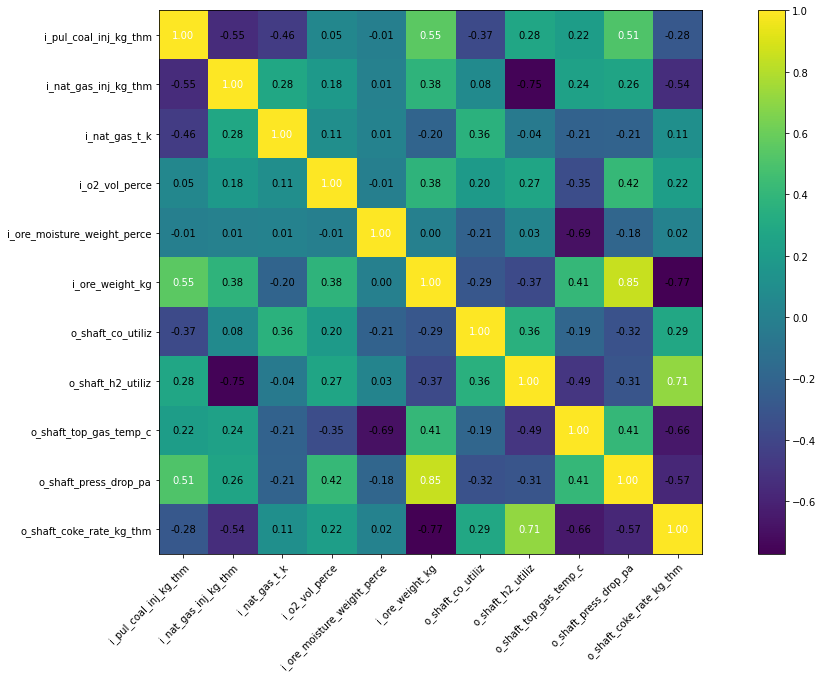

In [5]:
my_allInputs_shaft_names = ['i_pul_coal_inj_kg_thm','i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
                            'i_ore_moisture_weight_perce', 'i_ore_weight_kg', 'o_shaft_co_utiliz', 
                            'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 
                            'o_shaft_coke_rate_kg_thm']



cm = np.corrcoef(CFD_raw_data[my_allInputs_shaft_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_shaft_names, column_names=my_allInputs_shaft_names, figsize=(20, 10))
plt.show()

In [6]:
CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)

[[  1.           0.          37.9        ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.          37.9        ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.          37.9        ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [654.           0.         150.         ...   0.2177873    0.1135979
    0.4338012 ]
 [655.           0.         150.         ...   0.1865845    0.1268458
    0.4743676 ]
 [656.           0.         150.         ...   0.2246319    0.1110198
    0.4373359 ]]
(656, 29)


In [8]:
#######################################################

input_indeces  = [1, 2, 3, 4, 9, 11]
output_indeces = [19, 20, 21, 22, 23]                            

#######################################################

X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(656, 6)
(656, 5)
(524, 6)
(132, 6)
(524, 5)
(132, 5)


In [9]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

## Scale inputs (x)

In [10]:
###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations

## Scale outputs (y)

In [11]:
###################################################################
## standardize the y outputs

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

####################################################################

## Fit and DataLoader

In [12]:
def func_plot_performance(list_metric, the_string):
    
    list_samples = [i for i in range(len(list_metric))]
    
    plt.figure(figsize=(13,4))
    
    plt.scatter(list_samples, list_metric)
    
    ## plt.xlim(-1, 1)
    plt.ylim(0.7, 1.03)
    
    plt.title('metric during training ' + the_string)
    plt.xlabel('iteration/epoch')
    plt.ylabel('R**2')
    ## plt.legend()
    
    file_name = 'images/300dpiShaft' + the_string + '.png'
    plt.savefig(file_name, dpi=300)

    plt.show()

In [13]:

#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ## print(epoch, " loss= ", loss)
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
            
    func_plot_performance(list_metric, "No PDF shaping")
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################


In [14]:
#######################################################


def fit_y_scaled_PDF(num_epochs, model, loss_fn, loss_fn_PDF, opt):
    list_metric = []
    for epoch in range(num_epochs):
        
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            
            if epoch < int(num_epochs * switch_threshold):
                loss = loss_fn(pred_scaled, yb)
            else:
                opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )
                loss = loss_fn_PDF(pred_scaled, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            ## print(epoch, " loss= ", loss)
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
            
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
            
    func_plot_performance(list_metric, "With PDF shaping")
            
         
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

In [15]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

## Define NN architectures

In [16]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 5) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################


In [17]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(6, 5)       
        
        ## F2
        self.f2_linear1 = nn.Linear(6, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 5)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################


## Impulse Function for PDF shaping

Uses a gaussian basically

In [18]:
def ImpulseGaussian(x, mu, sigma): 
   
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   ) * torch.sqrt(torch.tensor(sigma) )    )
    
    right = torch.exp(   -(x - mu)**2 / (2 * sigma)    )
    
    vector_vals = left * right
    
    return vector_vals         ## .unsqueeze(0)

The variable left ends up being 1 scalar value. The variable right ends up being a vector of size 4000. The variable x is the range of errors from -N to N such as:

[-20, 19, ..., 0, ..., 19, 20].

N is selected. it is assumed that error diffs above 20 are rare.

The value mu is a scalar 0. A broadcast substraction is taken between the vector of size 4000 and the scalar 0. This results in a new vector of size 4000 which defines the impulse function. For example:

torch.Size([4000])


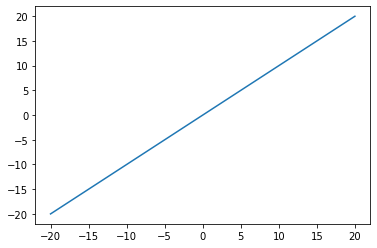

torch.Size([4000])


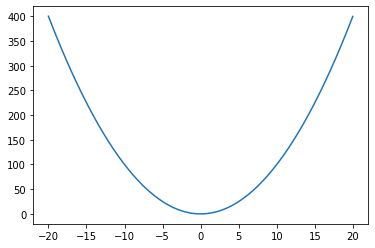

torch.Size([4000])


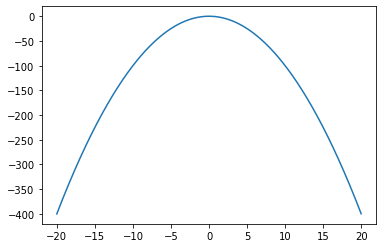

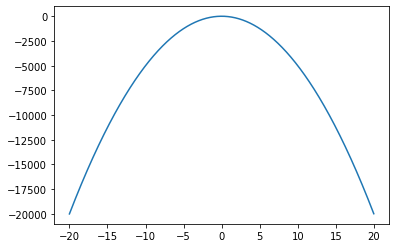

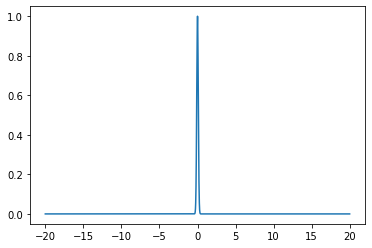

tensor(3.9894)


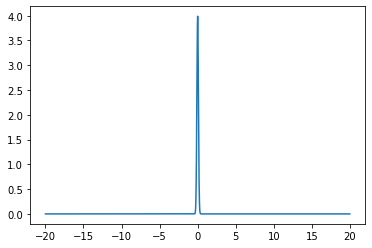

torch.Size([4000])


In [19]:
example_temp_x = torch.arange(-20, 20, 0.01)  

example_diff_range = example_temp_x - 0.0
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = (example_temp_x - 0.0)**2
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(example_temp_x - 0.0)**2
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(example_temp_x - 0.0)**2 / (2 * 0.01) 
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = torch.exp( -(example_temp_x - 0.0)**2 / (2 * 0.01) )
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_temp_left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   ) * torch.sqrt(torch.tensor(0.01) )    )
print(example_temp_left )

example_diff_range  = example_temp_left * example_diff_range 
plt.plot(example_temp_x, example_diff_range )
plt.show()

print(example_diff_range.size())

In [20]:
example_diff_range 

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [22]:
example_diff_range[1970:2030]

tensor([0.0443, 0.0595, 0.0792, 0.1042, 0.1358, 0.1753, 0.2239, 0.2833, 0.3547,
        0.4398, 0.5399, 0.6562, 0.7895, 0.9405, 1.1092, 1.2952, 1.4973, 1.7137,
        1.9419, 2.1785, 2.4197, 2.6609, 2.8969, 3.1225, 3.3322, 3.5207, 3.6827,
        3.8139, 3.9104, 3.9695, 3.9894, 3.9695, 3.9104, 3.8139, 3.6827, 3.5207,
        3.3322, 3.1225, 2.8969, 2.6609, 2.4197, 2.1785, 1.9419, 1.7137, 1.4973,
        1.2952, 1.1092, 0.9405, 0.7895, 0.6562, 0.5399, 0.4398, 0.3547, 0.2833,
        0.2239, 0.1753, 0.1358, 0.1042, 0.0792, 0.0595])

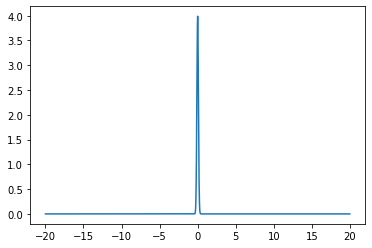

In [23]:
example_temp_y = ImpulseGaussian(example_temp_x, 0, 0.01)

plt.plot(example_temp_x, example_temp_y )

## Kernel Density Estimation for PDF approximation

In [24]:
def kernel_density(x_range, the_errors, h): 
    
    x_range = x_range.unsqueeze(0)
   
    the_errors = the_errors.unsqueeze(2)
    
    
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   )  )
    
    right = torch.exp(   -((x_range - the_errors)/h)**2 / (2)    )
    
    vector_vals = left * right
    
    ## density         = torch.mean( vector_vals, 0) / h
             
    return vector_vals

The kernel function does something very similar to the impulse function. The kernel help to create the other pdf for the errors in the range [-N, N]. The difference is that now we have batches and multiple outputs. If we had a batch of 1, with one output, then

y_pred - y_real = error

would give one scalar error value such as 2.3 or something. The 0 scalar value is what we would want if we had 100% accuracy. But we can assume an error scalar value such as 2.3.

the_errors variable below has a dimentions of [16x5] because we have batches of 16 and 5 outputs. Exactly like with the impulse func, we need the error range. The variable x_range is the range of errors from -N to N such as:

[-20, 19, ..., 0, ..., 19, 20].

N is selected. It is assumed that error differences above 20 are rare.

Since we have batches of 16 and 5 outputs, we take the broadcast diff between each of the values in the_errors and the x_range. A broadcast substraction is taken between the vector x_range of size 4000 and the values in the [16, 5] matrix. This results in a new matrix of size [16, 5, 4000].

The logic is the same as the impulse func, instead of zero like in the impulse func, for the kernel_density we have the loss errors

y_pred - y_real = error

so assume the value for batch 3 and output 4, we have value 2.3. This was the error (y_pred - y_real ). Now like with the impulse func, we need the pdf of that error so we compare it to the vector range x of 4000 and a broadcast substraction is taken between the vector x_range of size 4000 and the value [3, 4] = 2.3

For efficiency, this is generalized with tensor matrix multiplications and broadcasting.

Now we repeat the plotting as we did for the impulse function but for the error value [3, 4] = 2.3

torch.Size([4000])


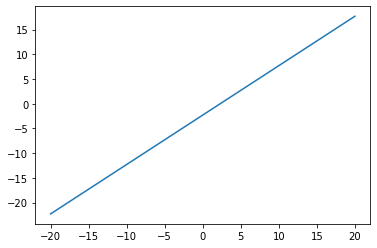

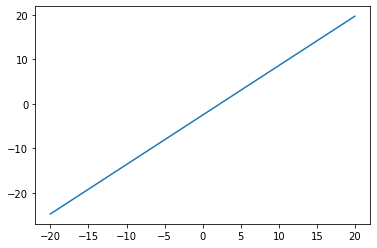

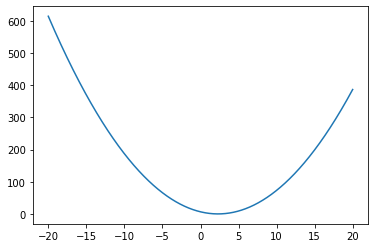

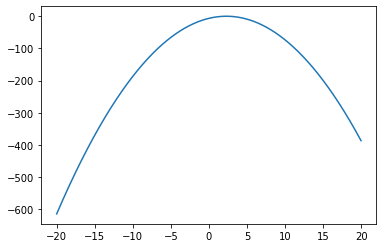

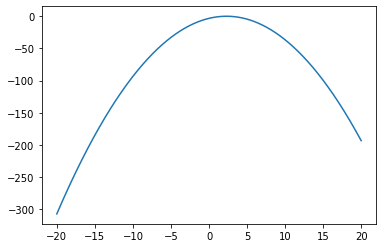

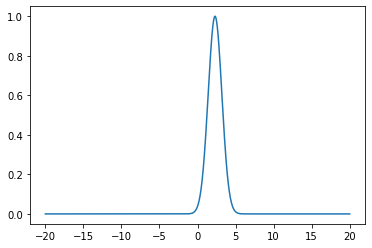

tensor(0.3989)


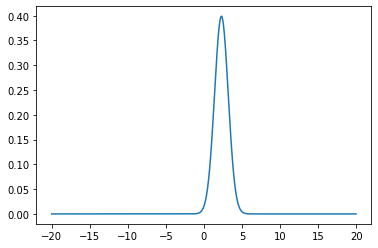

In [25]:

example_temp_x = torch.arange(-20, 20, 0.01)  

example_diff_range = example_temp_x - 2.3
print(example_diff_range.size())
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = (example_temp_x - 2.3)/h
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = (   (example_temp_x - 2.3)/h    )**2
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(   (example_temp_x - 2.3)/h    )**2
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range = -(   (example_temp_x - 2.3)/h    )**2 / (2)
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_diff_range =   torch.exp(  -(   (example_temp_x - 2.3)/h    )**2 / (2)   )
plt.plot(example_temp_x, example_diff_range )
plt.show()

example_temp_left = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   )  )
print(example_temp_left )
example_diff_range =   torch.exp(  -(   (example_temp_x - 2.3)/h    )**2 / (2)   )
example_diff_range  = example_temp_left * example_diff_range 
plt.plot(example_temp_x, example_diff_range )
plt.show()


In [26]:
example_diff_range

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [27]:
example_diff_range[1970:2030]

tensor([0.0061, 0.0063, 0.0066, 0.0068, 0.0070, 0.0072, 0.0074, 0.0077, 0.0079,
        0.0082, 0.0084, 0.0087, 0.0090, 0.0092, 0.0095, 0.0098, 0.0101, 0.0104,
        0.0107, 0.0111, 0.0114, 0.0117, 0.0121, 0.0124, 0.0128, 0.0132, 0.0136,
        0.0140, 0.0144, 0.0148, 0.0152, 0.0157, 0.0161, 0.0166, 0.0170, 0.0175,
        0.0180, 0.0185, 0.0190, 0.0196, 0.0201, 0.0207, 0.0212, 0.0218, 0.0224,
        0.0230, 0.0236, 0.0242, 0.0249, 0.0255, 0.0262, 0.0269, 0.0276, 0.0283,
        0.0291, 0.0298, 0.0306, 0.0313, 0.0321, 0.0329])

In [29]:
example_diff_range[2000:2500]

tensor([0.0152, 0.0157, 0.0161, 0.0166, 0.0170, 0.0175, 0.0180, 0.0185, 0.0190,
        0.0196, 0.0201, 0.0207, 0.0212, 0.0218, 0.0224, 0.0230, 0.0236, 0.0242,
        0.0249, 0.0255, 0.0262, 0.0269, 0.0276, 0.0283, 0.0291, 0.0298, 0.0306,
        0.0313, 0.0321, 0.0329, 0.0338, 0.0346, 0.0355, 0.0364, 0.0372, 0.0382,
        0.0391, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440, 0.0450, 0.0461, 0.0471,
        0.0482, 0.0494, 0.0505, 0.0516, 0.0528, 0.0540, 0.0552, 0.0564, 0.0577,
        0.0590, 0.0602, 0.0616, 0.0629, 0.0642, 0.0656, 0.0670, 0.0684, 0.0699,
        0.0713, 0.0728, 0.0743, 0.0758, 0.0774, 0.0790, 0.0805, 0.0822, 0.0838,
        0.0854, 0.0871, 0.0888, 0.0905, 0.0923, 0.0940, 0.0958, 0.0976, 0.0995,
        0.1013, 0.1032, 0.1051, 0.1070, 0.1090, 0.1109, 0.1129, 0.1149, 0.1169,
        0.1190, 0.1210, 0.1231, 0.1252, 0.1274, 0.1295, 0.1317, 0.1339, 0.1361,
        0.1383, 0.1406, 0.1428, 0.1451, 0.1474, 0.1497, 0.1521, 0.1544, 0.1568,
        0.1592, 0.1616, 0.1640, 0.1664, 

In [30]:
a = torch.tensor([[1,  9,  8, 7],
        [2,  1.0131, -0.6549, -1.4279],
        [3, -1.3350, -0.7694,  0.5600],
        [ 3, -0.9580,  0.3623,  0.2343]])
print(   torch.mean(a, 0)   )

tensor([2.2500, 1.9300, 1.7345, 1.5916])


Custom loss function for PDF shaping

The tenmsor x should be [-N, N] of size 4000 given my choice of step and N. The errors tensor becomes of size [16, 5] as it is [batches, outputs]. Impulse function returns a vector of size 4000 as previously described. Kernel desity returns a tensor of size [16, 5, 4000].

diff should be [16, 5, 4000]

In [31]:
x =torch.randint(3, 5, (3,))
y = torch.randint(10, (2, 4, 3))
print(x.size())
print(x)
print(y)
print(y.size())
res = y - x
print(res)
## print(   torch.mean(a, 0)   )

torch.Size([3])
tensor([3, 3, 3])
tensor([[[5, 0, 0],
         [9, 6, 9],
         [7, 1, 3],
         [1, 0, 2]],

        [[3, 0, 0],
         [0, 0, 5],
         [9, 7, 6],
         [3, 8, 1]]])
torch.Size([2, 4, 3])
tensor([[[ 2, -3, -3],
         [ 6,  3,  6],
         [ 4, -2,  0],
         [-2, -3, -1]],

        [[ 0, -3, -3],
         [-3, -3,  2],
         [ 6,  4,  3],
         [ 0,  5, -2]]])


In [80]:
def my_loss(output, target):
    
    x = torch.arange(-N_error_range, N_error_range, 0.01)                   ## the error is in this range 
    
    error = output.float() - target.float() 
    
    basisFunc   =  kernel_density(x, error, h)
    
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)  
    
    ## print(basisFunc.size())
    ## print(impulseFunc.size())
    
    diff = ( basisFunc.float() -  impulseFunc.float()  )        ## * h         ## h is ?? 
    ## print(  diff.size()   )
    
    ## there are 5 ish values and 3995 zeros, so get rid of zeros
    ## and then take the mean
    
    diffs_vector  = torch.reshape(diff, (-1,))
    diffs_vector = diffs_vector[diffs_vector > ignore_losses_threshold]
    
    diff = diffs_vector
    
    ## print(diff)
    ## print(   diff.size()  )
    
    loss = torch.mean(   (   diff  )**2    )    ## / h
    
    reg_sigma_func = (loss ** 2) * use_regularization
    
    loss = loss * ( 1.0 + reg_sigma_func )
    
    return loss

## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

In [34]:
def print_individual_Rsquare(pred_descaled, y_test_tr):
    vector_pred_descaled = pred_descaled.detach().numpy()
    vector_y_test_tr     = y_test_tr.numpy()

    for i in range(len(output_indeces)):
        ## print(vector_pred_descaled.shape)
        print("*****")
        print("*****")
        print('Testing R**2 - Output: ' + str(i), r2_score( vector_pred_descaled[:, i], vector_y_test_tr[:, i] ) )
        

0  loss=  tensor(0.5621, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1843, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.2003, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.1935, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.1701, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.1604, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0920, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0745, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.3381, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.1117, grad_fn=<MseLossBackward0>)
2000  loss=  tensor(0.1321, grad_fn=<MseLossBackward0>)
2200  loss=  tensor(0.1166, grad_fn=<MseLossBackward0>)
2400  loss=  tensor(0.2626, grad_fn=<MseLossBackward0>)
2600  loss=  tensor(0.0960, grad_fn=<MseLossBackward0>)
2800  loss=  tensor(0.1745, grad_fn=<MseLossBackward0>)
3000  loss=  tensor(0.1802, grad_fn=<MseLossBackward0>)
3200  loss=  tensor(0.3000, grad_fn=<MseLossBackward0>)
3400  loss=  tensor(0.1488, grad_fn=<MseLossBackward0>)

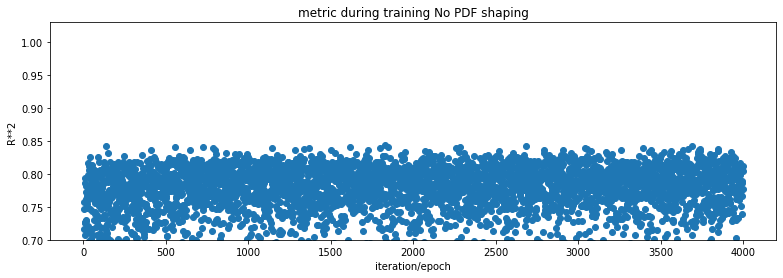

Training loss: tensor(0.1604, grad_fn=<MseLossBackward0>)
Training R**2: 0.8095440319825853
Test loss - scaled: tensor(0.1785, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(10829281., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7908092541505428
Testing R**2 - descaled: 0.7908093138533516
*****
*****
Testing R**2 - Output: 0 0.397430992910524
*****
*****
Testing R**2 - Output: 1 0.7647648488756348
*****
*****
Testing R**2 - Output: 2 0.9738081140004999
*****
*****
Testing R**2 - Output: 3 0.8520673784883096
*****
*****
Testing R**2 - Output: 4 0.9659752324829116


In [35]:
model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

print_individual_Rsquare(pred_descaled, y_test_tr)

## Use model to predict

In [36]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(46.458477, 47.27)
(43.862946, 45.78179)
(109.24742, 108.063)
(117044.74, 112853.0)
(462.6569, 449.35526)
**************************************************
preds, real
(48.052765, 48.07669)
(42.03545, 41.7481)
(164.61331, 160.8499)
(123792.484, 128726.7)
(418.71704, 418.3743)
**************************************************
preds, real
(46.689102, 47.56826)
(44.2311, 45.09411)
(170.9992, 174.3115)
(150218.38, 138650.4)
(413.01294, 404.5695)
**************************************************
preds, real
(48.917503, 45.34951)
(43.90847, 42.52338)
(70.638, 69.4575)
(130201.734, 132172.4)
(469.77115, 471.02084)
**************************************************
preds, real
(46.73222, 46.86535)
(43.942516, 44.21876)
(96.22558, 95.5999)
(120774.0, 117259.3)
(448.4617, 430.75656)
**************************************************
preds, real
(46.171127, 46.59507)
(45.61309, 45.58934)
(93.2087, 89.0167)
(138909.69, 142452.5)
(54

## Plotting

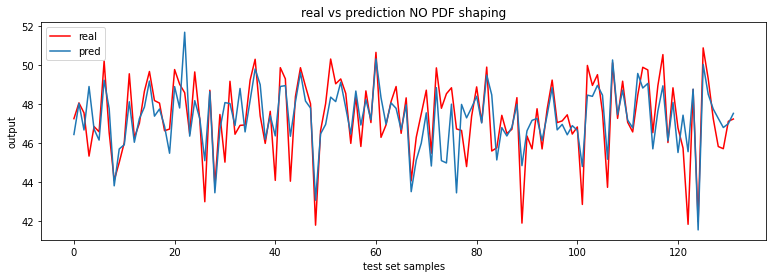

In [37]:
list_preds_y0 = [list_preds[i] for i in range(0, len(list_preds), 5)]
list_reals_y0 = [list_reals[i] for i in range(0, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y0, label= 'real', color='r' )
plt.plot(list_preds_y0, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y0ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

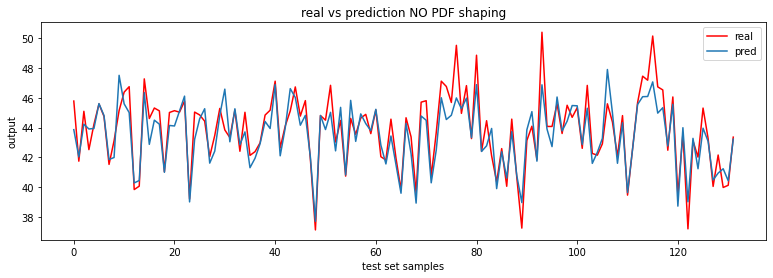

In [38]:
list_preds_y1 = [list_preds[i] for i in range(1, len(list_preds), 5)]
list_reals_y1 = [list_reals[i] for i in range(1, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y1, label= 'real', color='r' )
plt.plot(list_preds_y1, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y1ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

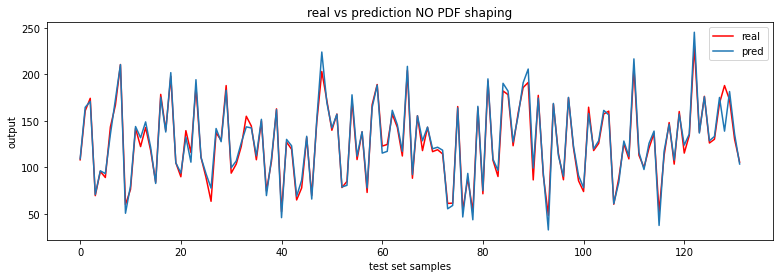

In [39]:
list_preds_y2 = [list_preds[i] for i in range(2, len(list_preds), 5)]
list_reals_y2 = [list_reals[i] for i in range(2, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y2, label= 'real', color='r' )
plt.plot(list_preds_y2, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y2ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

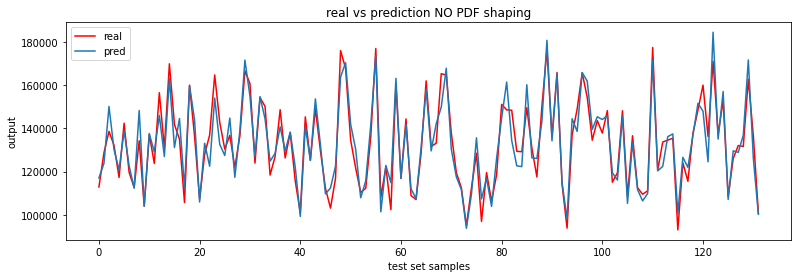

In [40]:
list_preds_y3 = [list_preds[i] for i in range(3, len(list_preds), 5)]
list_reals_y3 = [list_reals[i] for i in range(3, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y3, label= 'real', color='r' )
plt.plot(list_preds_y3, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y3ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

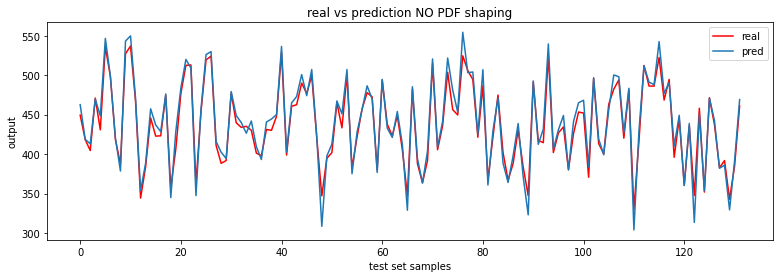

In [41]:
list_preds_y4 = [list_preds[i] for i in range(4, len(list_preds), 5)]
list_reals_y4 = [list_reals[i] for i in range(4, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y4, label= 'real', color='r' )
plt.plot(list_preds_y4, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y4ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


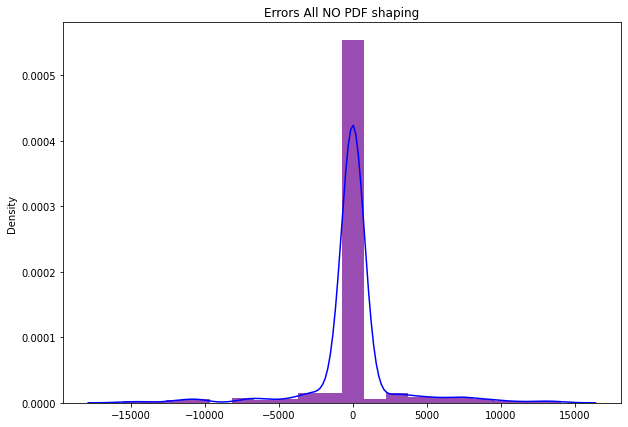

In [42]:
n_bins = 20

y_pred = np.array(list_preds)

y_real = np.array(list_reals)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error,     bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors All NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


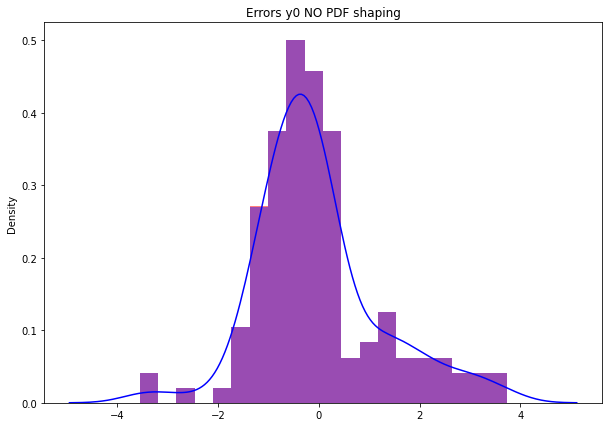

In [43]:
n_bins = 20

y_pred = np.array(list_preds_y0)

y_real = np.array(list_reals_y0)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors y0 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


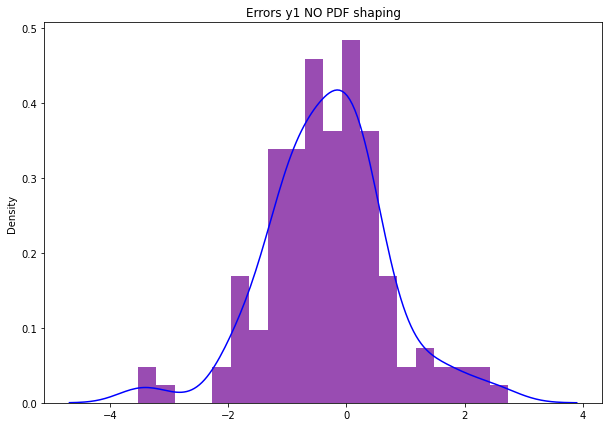

In [44]:
n_bins = 20

y_pred = np.array(list_preds_y1)

y_real = np.array(list_reals_y1)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors y1 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


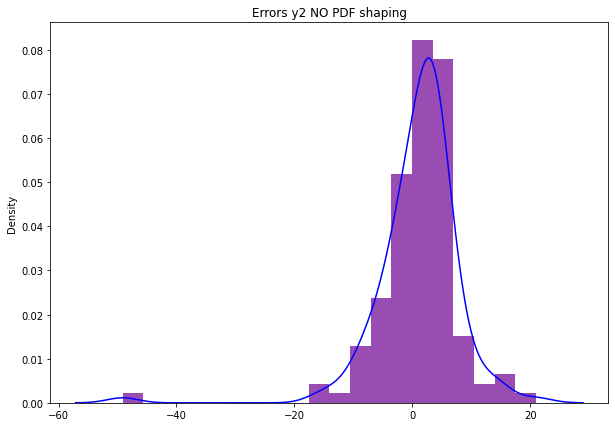

In [45]:
n_bins = 20

y_pred = np.array(list_preds_y2)

y_real = np.array(list_reals_y2)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")


plt.title('Errors y2 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


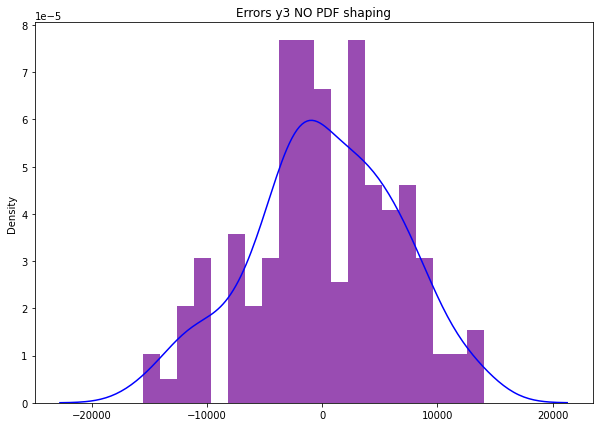

In [46]:
n_bins = 20

y_pred = np.array(list_preds_y3)

y_real = np.array(list_reals_y3)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")


plt.title('Errors y3 NO PDF shaping')


plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


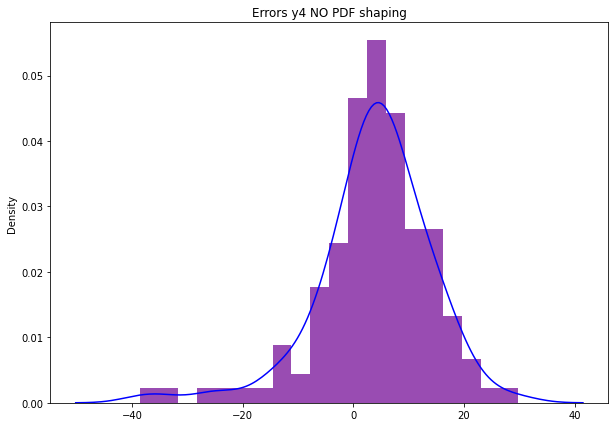

In [47]:
n_bins = 20

y_pred = np.array(list_preds_y4)

y_real = np.array(list_reals_y4)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title('Errors y4 NO PDF shaping')


plt.show()

## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

In [48]:
def print_individual_Rsquare(pred_descaled, y_test_tr):
    vector_pred_descaled = pred_descaled.detach().numpy()
    vector_y_test_tr     = y_test_tr.numpy()

    for i in range(len(output_indeces)):
        ## print(vector_pred_descaled.shape)
        print("*****")
        print("*****")
        print('Testing R**2 - Output: ' + str(i), r2_score( vector_pred_descaled[:, i], vector_y_test_tr[:, i] ) )
        

0  loss=  tensor(0.1422, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.3028, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.3321, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.1308, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.1613, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.2559, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.1589, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.2013, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.1404, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.1460, grad_fn=<MseLossBackward0>)
2000  loss=  tensor(0.1390, grad_fn=<MseLossBackward0>)
2200  loss=  tensor(0.1073, grad_fn=<MseLossBackward0>)
2400  loss=  tensor(0.1357, grad_fn=<MseLossBackward0>)
2600  loss=  tensor(0.0757, grad_fn=<MseLossBackward0>)
2800  loss=  tensor(0.2564, grad_fn=<MseLossBackward0>)
3000  loss=  tensor(0.0621, grad_fn=<MseLossBackward0>)
3200  loss=  tensor(0.0095, grad_fn=<MulBackward0>)
3400  loss=  tensor(0.0095, grad_fn=<MulBackward0>)
3600  l

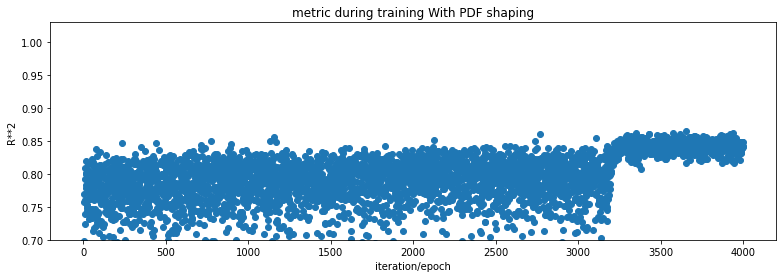

Training loss: tensor(0.1372, grad_fn=<MseLossBackward0>)
Training R**2: 0.8294985427436913
Test loss - scaled: tensor(0.1660, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(7544887., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.8082104972441193
Testing R**2 - descaled: 0.8082105558000745
*****
*****
Testing R**2 - Output: 0 0.38479224209188645
*****
*****
Testing R**2 - Output: 1 0.790191937606204
*****
*****
Testing R**2 - Output: 2 0.9763315739306366
*****
*****
Testing R**2 - Output: 3 0.8981471304384611
*****
*****
Testing R**2 - Output: 4 0.9915898956371272


In [51]:
model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn     = F.mse_loss
loss_fn_PDF = my_loss

fit_y_scaled_PDF(N_EPOCHS, model, loss_fn, loss_fn_PDF, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))


print_individual_Rsquare(pred_descaled, y_test_tr)

## Use model to predict

In [52]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])
        

**************************************************
preds, real
(46.483665, 47.27)
(44.40025, 45.78179)
(107.875015, 108.063)
(114481.016, 112853.0)
(448.8092, 449.35526)
**************************************************
preds, real
(47.828083, 48.07669)
(42.077095, 41.7481)
(162.71852, 160.8499)
(124453.25, 128726.7)
(422.15833, 418.3743)
**************************************************
preds, real
(46.518616, 47.56826)
(44.514904, 45.09411)
(170.98778, 174.3115)
(146122.25, 138650.4)
(410.06738, 404.5695)
**************************************************
preds, real
(47.862274, 45.34951)
(43.6879, 42.52338)
(71.21217, 69.4575)
(132165.95, 132172.4)
(464.54633, 471.02084)
**************************************************
preds, real
(47.161983, 46.86535)
(44.463028, 44.21876)
(94.50166, 95.5999)
(118374.7, 117259.3)
(433.3043, 430.75656)
**************************************************
preds, real
(48.269123, 46.59507)
(47.201443, 45.58934)
(87.25177, 89.0167)
(131298.84, 142452

## Plotting

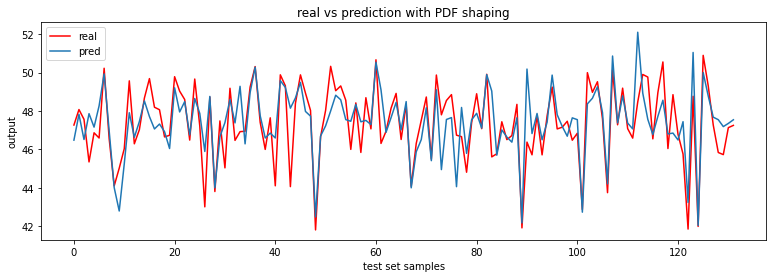

In [53]:
list_preds_y0 = [list_preds[i] for i in range(0, len(list_preds), 5)]
list_reals_y0 = [list_reals[i] for i in range(0, len(list_reals), 5)]


plt.figure(figsize=(13,4))

plt.plot(list_reals_y0, label= 'real', color='r' )
plt.plot(list_preds_y0, label= 'pred')

    
plt.title('real vs prediction with PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y0ShaftRealToPredictedWithPDFshaping.png', dpi=300)


plt.show()

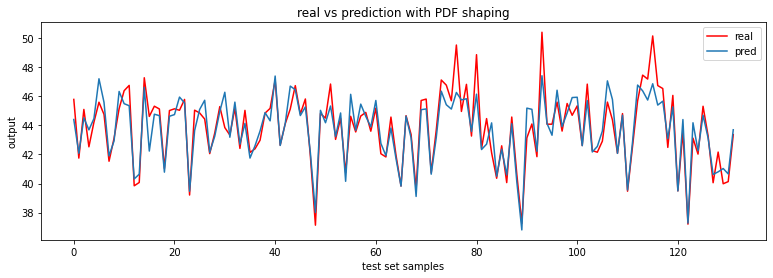

In [54]:
list_preds_y1 = [list_preds[i] for i in range(1, len(list_preds), 5)]
list_reals_y1 = [list_reals[i] for i in range(1, len(list_reals), 5)]


plt.figure(figsize=(13,4))

plt.plot(list_reals_y1, label= 'real', color='r' )
plt.plot(list_preds_y1, label= 'pred')

    
plt.title('real vs prediction with PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y1ShaftRealToPredictedWithPDFshaping.png', dpi=300)


plt.show()

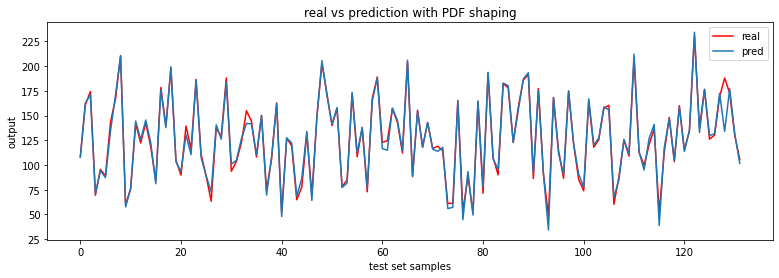

In [55]:
list_preds_y2 = [list_preds[i] for i in range(2, len(list_preds), 5)]
list_reals_y2 = [list_reals[i] for i in range(2, len(list_reals), 5)]


plt.figure(figsize=(13,4))

plt.plot(list_reals_y2, label= 'real', color='r' )
plt.plot(list_preds_y2, label= 'pred')

    
plt.title('real vs prediction with PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y2ShaftRealToPredictedWithPDFshaping.png', dpi=300)


plt.show()

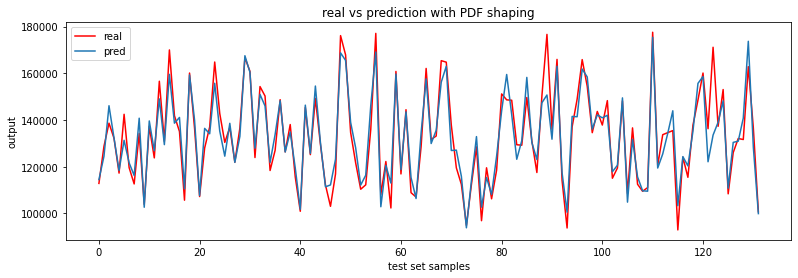

In [56]:
list_preds_y3 = [list_preds[i] for i in range(3, len(list_preds), 5)]
list_reals_y3 = [list_reals[i] for i in range(3, len(list_reals), 5)]


plt.figure(figsize=(13,4))

plt.plot(list_reals_y3, label= 'real', color='r' )
plt.plot(list_preds_y3, label= 'pred')

    
plt.title('real vs prediction with PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y3ShaftRealToPredictedWithPDFshaping.png', dpi=300)


plt.show()

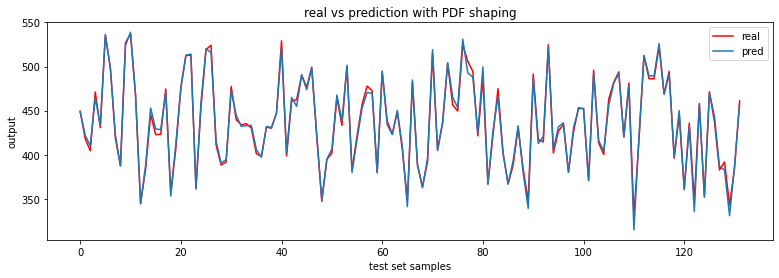

In [57]:
list_preds_y4 = [list_preds[i] for i in range(4, len(list_preds), 5)]
list_reals_y4 = [list_reals[i] for i in range(4, len(list_reals), 5)]


plt.figure(figsize=(13,4))

plt.plot(list_reals_y4, label= 'real', color='r' )
plt.plot(list_preds_y4, label= 'pred')

    
plt.title('real vs prediction with PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y4ShaftRealToPredictedWithPDFshaping.png', dpi=300)


plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


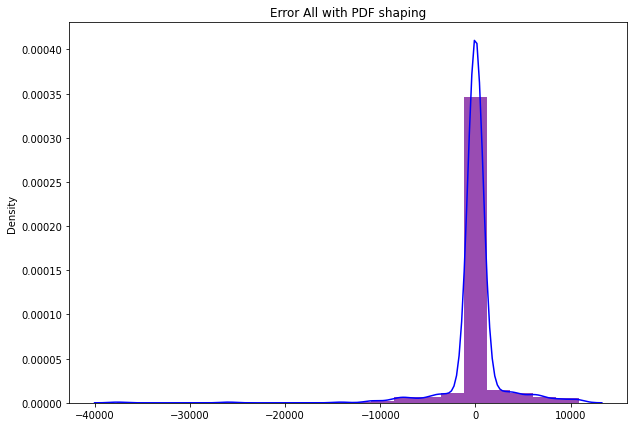

In [58]:
n_bins = 20

y_pred = np.array(list_preds)

y_real = np.array(list_reals)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title("Error All with PDF shaping")

plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


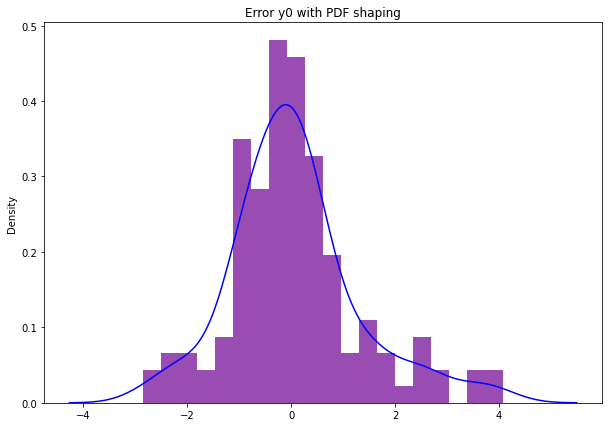

In [59]:
n_bins = 20

y_pred = np.array(list_preds_y0)

y_real = np.array(list_reals_y0)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title("Error y0 with PDF shaping")

plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


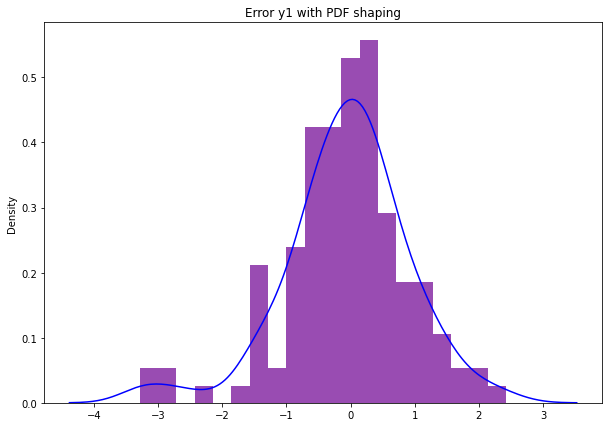

In [60]:
n_bins = 20

y_pred = np.array(list_preds_y1)

y_real = np.array(list_reals_y1)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title("Error y1 with PDF shaping")

plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


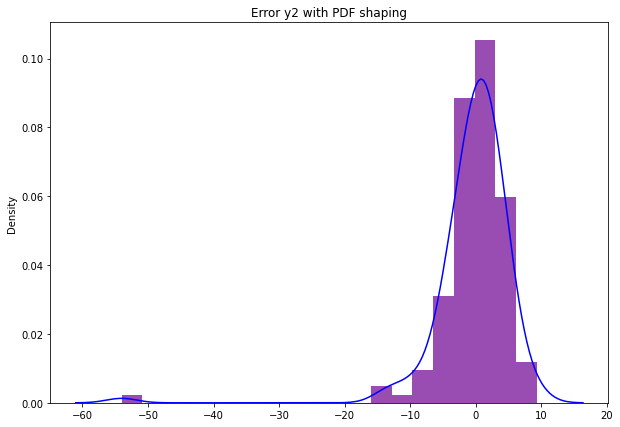

In [61]:
n_bins = 20

y_pred = np.array(list_preds_y2)

y_real = np.array(list_reals_y2)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title("Error y2 with PDF shaping")

plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


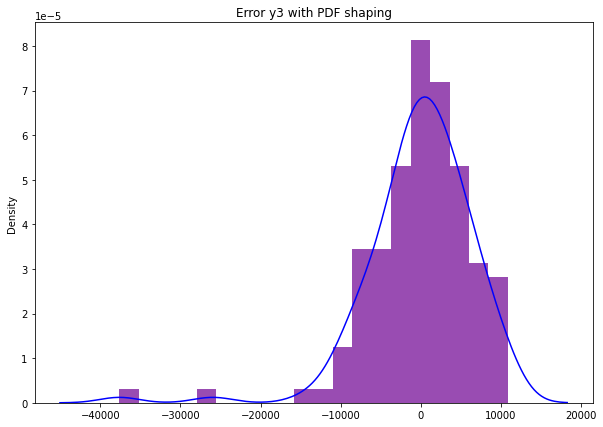

In [62]:
n_bins = 20

y_pred = np.array(list_preds_y3)

y_real = np.array(list_reals_y3)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(    error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title("Error y3 with PDF shaping")

plt.show()

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


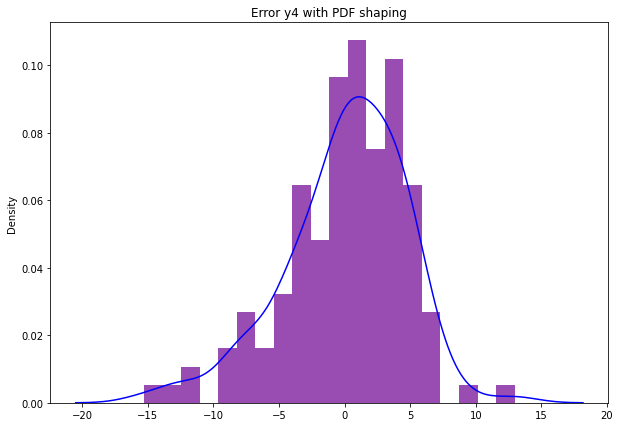

In [63]:
n_bins = 20

y_pred = np.array(list_preds_y4)

y_real = np.array(list_reals_y4)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)

sns.distplot(error, bins=n_bins, color="blue")

plt.title("Error y4 with PDF shaping")

plt.show()

## Use PDF shaping with regularization

In [104]:

use_regularization = 1.0

learning_rate_pdfcontrol  =  0.001
                   

In [105]:
def print_individual_Rsquare(pred_descaled, y_test_tr):
    vector_pred_descaled = pred_descaled.detach().numpy()
    vector_y_test_tr     = y_test_tr.numpy()

    for i in range(len(output_indeces)):
        ## print(vector_pred_descaled.shape)
        print("*****")
        print("*****")
        print('Testing R**2 - Output: ' + str(i), r2_score( vector_pred_descaled[:, i], vector_y_test_tr[:, i] ) )
     

0  loss=  tensor(0.2138, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1413, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.1735, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.1296, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.1032, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.2267, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.2005, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.1053, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.2222, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.1446, grad_fn=<MseLossBackward0>)
2000  loss=  tensor(0.0912, grad_fn=<MseLossBackward0>)
2200  loss=  tensor(0.0866, grad_fn=<MseLossBackward0>)
2400  loss=  tensor(0.1192, grad_fn=<MseLossBackward0>)
2600  loss=  tensor(0.1171, grad_fn=<MseLossBackward0>)
2800  loss=  tensor(0.2077, grad_fn=<MseLossBackward0>)
3000  loss=  tensor(0.0759, grad_fn=<MseLossBackward0>)
3200  loss=  tensor(0.0095, grad_fn=<MulBackward0>)
3400  loss=  tensor(0.0095, grad_fn=<MulBackward0>)
3600  l

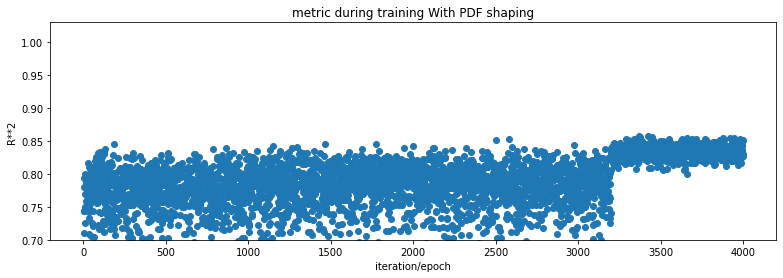

Training loss: tensor(0.1417, grad_fn=<MseLossBackward0>)
Training R**2: 0.8342778861818161
Test loss - scaled: tensor(0.1814, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(10480130., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.8031420696878268
Testing R**2 - descaled: 0.8031420555199962
*****
*****
Testing R**2 - Output: 0 0.3957098472931042
*****
*****
Testing R**2 - Output: 1 0.7990421399805893
*****
*****
Testing R**2 - Output: 2 0.9755316515687114
*****
*****
Testing R**2 - Output: 3 0.8543187713284364
*****
*****
Testing R**2 - Output: 4 0.9911078719987725


In [106]:
model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn     = F.mse_loss
loss_fn_PDF = my_loss

fit_y_scaled_PDF(N_EPOCHS, model, loss_fn, loss_fn_PDF, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))


print_individual_Rsquare(pred_descaled, y_test_tr)

## Export model to ONNX

In [108]:
'''

model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s536ShaftPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''

'\n\nmodel.eval()\n\ndummy_input = torch.randn(1, 6)\n\n\ninput_names = ["input1"]\noutput_names = ["output1", "output2"]\n\ntorch.onnx.export(\n  model, \n  dummy_input, \n  "ONNXmodels/s536ShaftPDFshapingRC.onnx", \n  verbose=False, \n  input_names  = input_names,\n  output_names = output_names\n)\n\n'